In [1]:
%matplotlib widget
import os  
import sys  
sys.path.insert(0, os.getenv('HOME')+'/pycode/MscThesis/')
from amftrack.pipeline.functions.post_processing.extract_study_zone import *
import pandas as pd
import ast
from amftrack.plotutil import plot_t_tp1
from scipy import sparse
from datetime import datetime
import pickle
import scipy.io as sio
from pymatreader import read_mat
from matplotlib import colors
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import frangi
from skimage import filters
from random import choice
import scipy.sparse
import os
from skimage.feature import hessian_matrix_det
from amftrack.pipeline.paths.directory import run_parallel, find_state, directory_scratch, directory_project
from amftrack.notebooks.analysis.util import * 
from scipy import stats
from scipy.ndimage.filters import uniform_filter1d
from collections import Counter
from IPython.display import clear_output
from amftrack.notebooks.analysis.data_info import *
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
plt.rcParams.update({
    "font.family": "verdana",
'font.weight' : 'normal',
'font.size': 20})
from amftrack.plotutil import plot_node_skel
from amftrack.notebooks.validation.util import *
from amftrack.pipeline.paths.directory import *
from amftrack.util import *
from amftrack.notebooks.post_processing.util import *
import pickle
from amftrack.pipeline.functions.image_processing.experiment_class_surf import Experiment, save_graphs, load_graphs
from amftrack.plotutil import plot_t_tp1, plot_node_skel
import imageio
from amftrack.pipeline.functions.image_processing.experiment_class_surf import plot_raw_plus,find_node_equ, get_distance



In [2]:
directory = directory_project
update_analysis_info(directory)
analysis_info = get_analysis_info(directory)
select = analysis_info

In [3]:
num = 9
rows = [row for (index, row) in select.iterrows()]
for index,row in enumerate(rows):
    path = f'{directory}{row["folder_analysis"]}'
    print(index,row["Plate"])
    try:
        a = np.load(f'{path}/center.npy')
    except:
        print(index,row["Plate"])
    if index == num:
        path_exp = f'{directory}{row["path_exp"]}'
        exp = pickle.load(open(path_exp, "rb"))
        exp.dates.sort()
        break

0 799
1 790
2 792
3 800
4 22
4 22
5 80
6 10
7 76
8 102
9 94


In [4]:
load_graphs(exp,indexes = range(98,100))


In [5]:
end = 1
hyph_label = end
hyph= [hyph for hyph in exp.hyphaes if hyph.end.label == end][0]


In [6]:
t0 = hyph.ts[0]
exp = hyph.experiment
thresh = 1600
junctions_found= [hyph.end.neighbours(t0)[0]]
ts = []
mult = []
begin = 0
end = 99
for t in range(begin,end):
    G = exp.nx_graph[t]
    G = G.subgraph(nx.node_connected_component(G, hyph.end.label))
    if hyph.end.degree(t)==1:
        nodes,edges = hyph.get_nodes_within(t)
        potentials = []
        nodes = [Node(node,exp) for node in nodes]
        try:
            last_junction_index = nodes.index(junctions_found[-1])
        except:
            last_junction_index =0 
        for node in nodes[last_junction_index+1:-1]:
            dist = np.linalg.norm(node.pos(t)-hyph.end.pos(t))
            #To avoid detecting two times the same  node with different labels
            dists_junction_found = [np.inf]+[np.linalg.norm(node.pos(t)-nodo.pos(t)) for nodo in junctions_found if nodo.is_in(t)] 
            if dist<thresh and min(dists_junction_found)>40 and(node not in junctions_found):
                extra_hypha_neighbours = [nodo for nodo in node.neighbours(t) if nodo not in nodes]
                tips = [nodo for nodo in extra_hypha_neighbours if nx.edge_connectivity(G,nodo.label,node.label)==1]
                if len(tips) == node.degree(t)-2:
                    junctions_found.append(node)  
                    mult.append(node.degree(t)-2)
                    ts.append(t)

In [7]:
tf = 99
junctions_found_tf  = [find_node_equ(node,tf) for node in junctions_found]
junctions_found_label  = [node.label for node in junctions_found_tf]

In [8]:
def find_hyph_root(exp,node,t):
    for hypha in exp.hyphaes:
        if hypha.get_root(t)==node:
            return(hypha)
    return(None)

In [9]:
hyphs = [find_hyph_root(exp,node,tf) for node in junctions_found_tf]

In [10]:
hyphs_branch = [hyph for hyph in hyphs if not hyph is None]

In [23]:
hyphs_branch_ends = [hyph.end.label for hyph in hyphs_branch]

In [25]:
np.save('hyphs_branch_ends',hyphs_branch_ends)

In [14]:
lengths = [get_length_um(hyph,tf) for hyph in hyphs_branch]

In [15]:
def get_time(exp,t,tp1):#redefined here to avoid loop in import
    seconds = (exp.dates[tp1]-exp.dates[t]).total_seconds()
    return(seconds/3600)

In [16]:
t_real = [get_time(exp,t0,t) for t in ts]

Text(0.5, 0, 'time since emergence (h)')

Text(0, 0.5, 'length of branches')

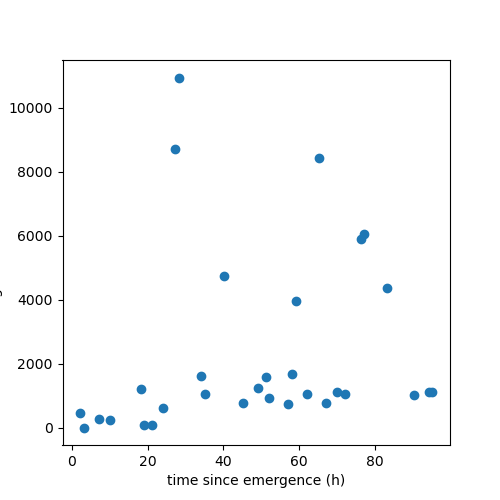

In [21]:

plt.rcParams.update(plt.rcParamsDefault)
%matplotlib widget
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.scatter(t_real,lengths)
ax.set_xlabel('time since emergence (h)')
ax.set_ylabel('length of branches')

In [52]:
for hyph in hyphs_branch:
    try:
        get_length_um(hyph,tf)
    except nx.exception.NetworkXNoPath:
        print(hyph)

457.0170005451646

0.0

276.566798898424

221.34917273837007

1205.6219230606607

80.12660971187721

80.12660971187721

596.3350310961839

8706.824710143997

10942.809659240138

1624.6032829939188

1039.3097610527393

4751.837810958388

753.295611971228

1250.2862138626633

1566.6320925050165

924.6735581690721

734.691504235205

1671.390778944101

3963.058118256445

1057.901529352113

8440.015937156637

754.2205778204118

1102.8399490549355

1058.5263869363419

5882.940965325027

6050.942302748588

4359.231958483367

1009.7825244915

1125.393739112089

1109.847241083371

In [33]:
hyph = choice(hyphs_branch)

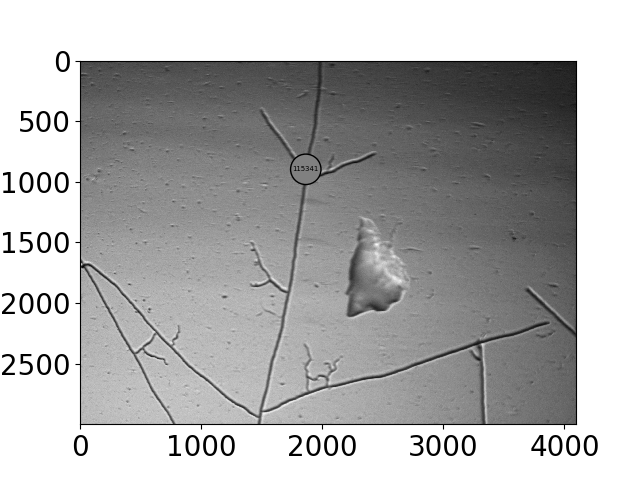

In [44]:
hyph.get_root(tf).show_source_image(tf,tf)

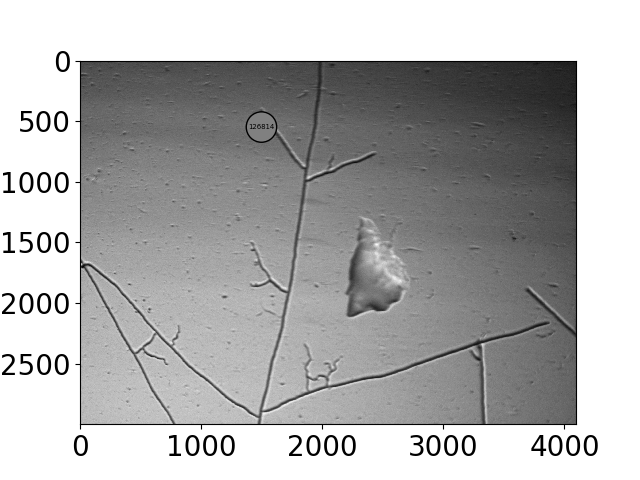

In [45]:
t = tf
find_node_equ_last_pos(hyph.end,t).show_source_image(t,t)

In [46]:
find_node_equ_last_pos(hyph.end,t).degree(t)

0

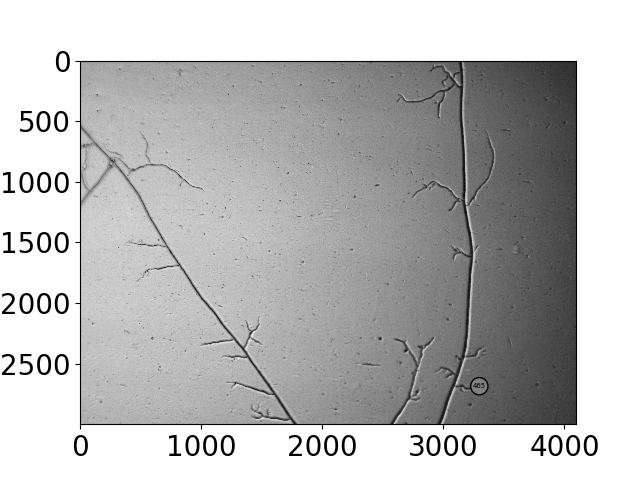

In [19]:
hyph.end.show_source_image(44,45)

In [12]:
def get_nodes_within(hypha, t):
    nodes = nx.shortest_path(
        hypha.experiment.nx_graph[t],
        source=hypha.get_root(t).label,
        target=find_node_equ_last_pos(hypha.end,t).label,
        weight="weight",
    )
    edges = [
        Edge(
            hypha.experiment.get_node(nodes[i]),
            hypha.experiment.get_node(nodes[i + 1]),
            hypha.experiment,
        )
        for i in range(len(nodes) - 1)
    ]
    return (nodes, edges)
def get_length_um(hypha, t):
    pixel_conversion_factor = 1.725
    nodes, edges = get_nodes_within(hypha,t)
    length = 0
    for edge in edges:
        length_edge = 0
        pixels = edge.pixel_list(t)
        for i in range(len(pixels) // 10 + 1):
            if i * 10 <= len(pixels) - 1:
                length_edge += np.linalg.norm(
                    np.array(pixels[i * 10])
                    - np.array(pixels[min((i + 1) * 10, len(pixels) - 1)])
                )
        #         length_edge+=np.linalg.norm(np.array(pixels[len(pixels)//10-1*10-1])-np.array(pixels[-1]))
        length += length_edge
    return length * pixel_conversion_factor

In [13]:
def find_node_equ_last_pos(node,t):
    assert node.ts()[0]<=t
    if node.is_in(t):
            return(node)
    else:
        mini = np.inf
        poss = node.experiment.positions[t]
        pos_root = node.pos(node.ts()[-1])
        for node_candidate in node.experiment.nx_graph[t]:
            if node.experiment.nx_graph[t].degree(node_candidate)>=1:
                distance = np.linalg.norm(poss[node_candidate] - pos_root)
                if distance < mini:
                    mini = distance
                    identifier = node_candidate
        return(Node(identifier,node.experiment))